In [1]:
import numpy as np
from matplotlib import pyplot as plt
from offline_RL import q_val_iter, get_q_func, get_policy, get_random_policy, offline_q_val_iter, gen_dataset
from scipy.spatial.distance import pdist, squareform, cdist
from sklearn.metrics.pairwise import rbf_kernel

from fnc_compress import *

import copy

####Setup the MDP 
n_action = 5
n_state = 100
np.random.seed(0)
rewards = np.random.randint(0,100,size=(n_state,n_action))
#plt.plot(rewards)
np.random.seed(0)
t_matrix = np.random.rand(n_state,n_action,n_state)
#plt.figure()
#plt.plot(t_matrix[0][0])
sums = []
for i in range(n_state):
    for j in range(n_action):
        t_matrix[i][j] = t_matrix[i][j]/np.sum(t_matrix[i][j])
        sums.append(np.sum(t_matrix[i][j]))
#check to make sure valid transition probabilities have been create
# plt.plot(sums)
gamma = 0.99

dataset_len = 100
lamd = 1
# delta_tol = 0.01
delta_tol =  0.92

num_agents = 4

# Adj = np.array([[1/3, 1/3, 0, 1/3], 
#                 [1/3, 1/3, 1/3, 0],
#                 [0, 1/3, 1/3, 1/3],
#                 [1/3, 0, 1/3, 1/3]])
share_rate = 0.01
Adj = np.array([[1-2*share_rate, share_rate, 0, share_rate], 
                 [share_rate, 1-2*share_rate, share_rate, 0],
                 [0, share_rate, 1-2*share_rate, share_rate],
                 [share_rate, 0, share_rate, 1-2*share_rate]])
nodelist = list(range(0,num_agents))

def cycle(my_list, start_at):
    count = 0
    newlst = []
    while count<4 :
        newlst.append(my_list[start_at])
        start_at = (start_at + 1) % len(my_list)
        count += 1
    return newlst

In [3]:
state_skip = n_state/num_agents
for a in range(num_agents):
    print(np.arange(a*state_skip,(a+1)*state_skip))

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124.]
[125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138.
 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152.
 153. 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166.
 167. 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180.
 181. 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194.
 195. 196.

In [4]:

# dataset = np.zeros((dataset_len,3,num_agents))
subX = np.zeros((dataset_len,2,num_agents))
subY = np.zeros((dataset_len,1,num_agents))

for a in range(num_agents):
    for k in range(dataset_len):
        # state = np.random.choice(n_state,size=1)[0]
        state = int(np.random.choice(np.arange(a*state_skip,(a+1)*state_skip),size=1)[0])
        action = np.random.choice(n_action,size=1)[0]
        # dataset.append(np.array([state,action,int(np.random.choice(n_state,size=1,p=t_matrix[state][action]))]))
        # dataset[k,:,a] = np.array([state,action,int(np.random.choice(n_state,size=1,p=t_matrix[state][action]))])
        subX[k,:,a] = np.array([state,action])
        subY[k,:,a] = np.array([int(np.random.choice(n_state,size=1,p=t_matrix[state][action]))])

In [5]:
rcond_value = 1e-5

N_kernel = 3
sigmalist =[1.45,0.48,0.29]
etalist = [0.5,0.3,0.2]

nodes = np.arange(0,4)
subDx = {}
subDy = {}
weightDxx = {}
weightDyx = {}
dict_sizes = np.zeros(num_agents)
for j in range(0,num_agents):
    print('Compressing dictionary in node ',j)
    subDx[j],subDy[j],dict_inds = compressD(subX[:,:,j],subY[:,:,j],delta_tol,sigmalist,etalist)
    print('Shape of dictionary: ',subDx[j].shape)
    dict_sizes[j] = subDx[j].shape[0]
    weightDxx[j],weightDyx[j]=weightAverage(subY[:,:,j],subX[:,:,j],subDy[j],subDx[j],sigmalist,etalist,rcond_value)

Compressing dictionary in node  0
Shape of dictionary:  (100, 2)
Compressing dictionary in node  1
Shape of dictionary:  (100, 2)
Compressing dictionary in node  2
Shape of dictionary:  (100, 2)
Compressing dictionary in node  3
Shape of dictionary:  (100, 2)


In [96]:
np.shape(weightDxx[j])

(100,)

--------------
Iteration 1
--------------
Working on node  0
list starting at node [0, 1, 2, 3]
Shape of projected sparse Dictionary : 300

(300, 300)
--------------
Working on node  1
list starting at node [1, 2, 3, 0]
Shape of projected sparse Dictionary : 300

(300, 300)
--------------
Working on node  2
list starting at node [2, 3, 0, 1]
Shape of projected sparse Dictionary : 300

(300, 300)
--------------
Working on node  3
list starting at node [3, 0, 1, 2]
Shape of projected sparse Dictionary : 300

(300, 300)
--------------
Working on node  0
list starting at node [0, 1, 2, 3]
Shape of projected sparse Dictionary : 400

(400, 900)
--------------
Working on node  1
list starting at node [1, 2, 3, 0]
Shape of projected sparse Dictionary : 400

(400, 900)
--------------
Working on node  2
list starting at node [2, 3, 0, 1]
Shape of projected sparse Dictionary : 400

(400, 900)
--------------
Working on node  3
list starting at node [3, 0, 1, 2]
Shape of projected sparse Dictionary

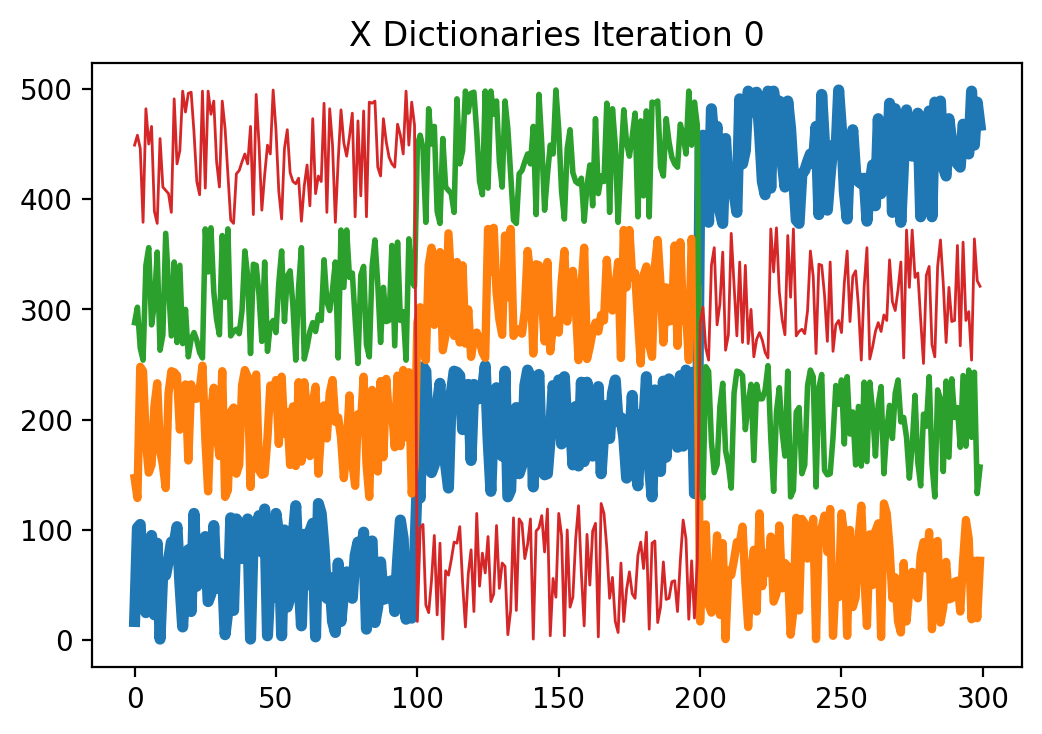

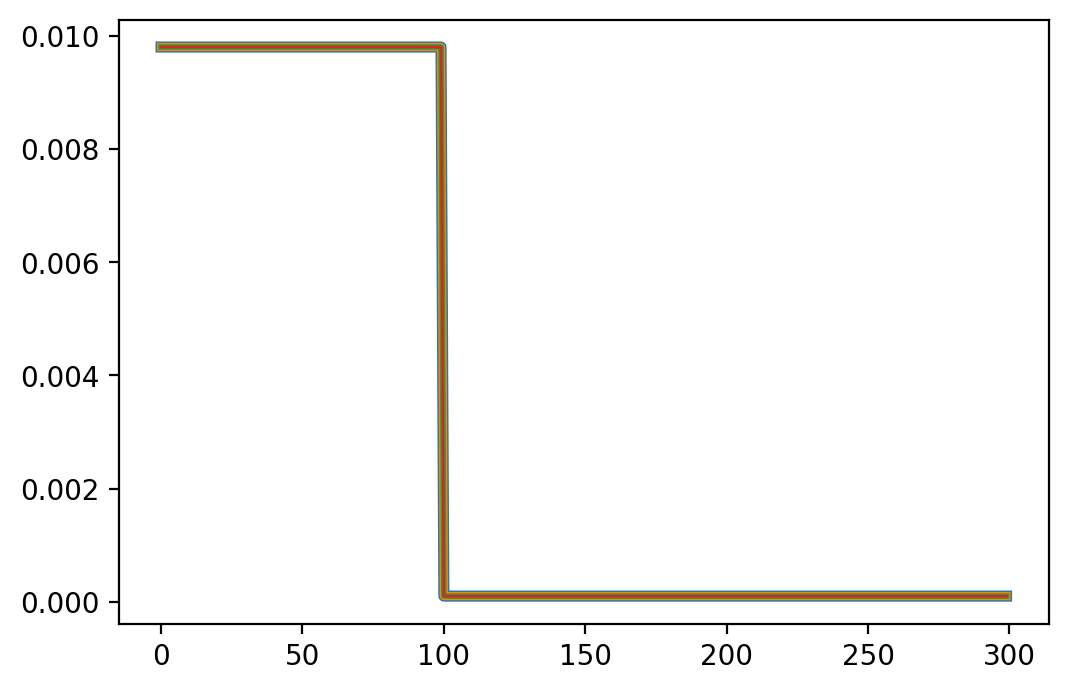

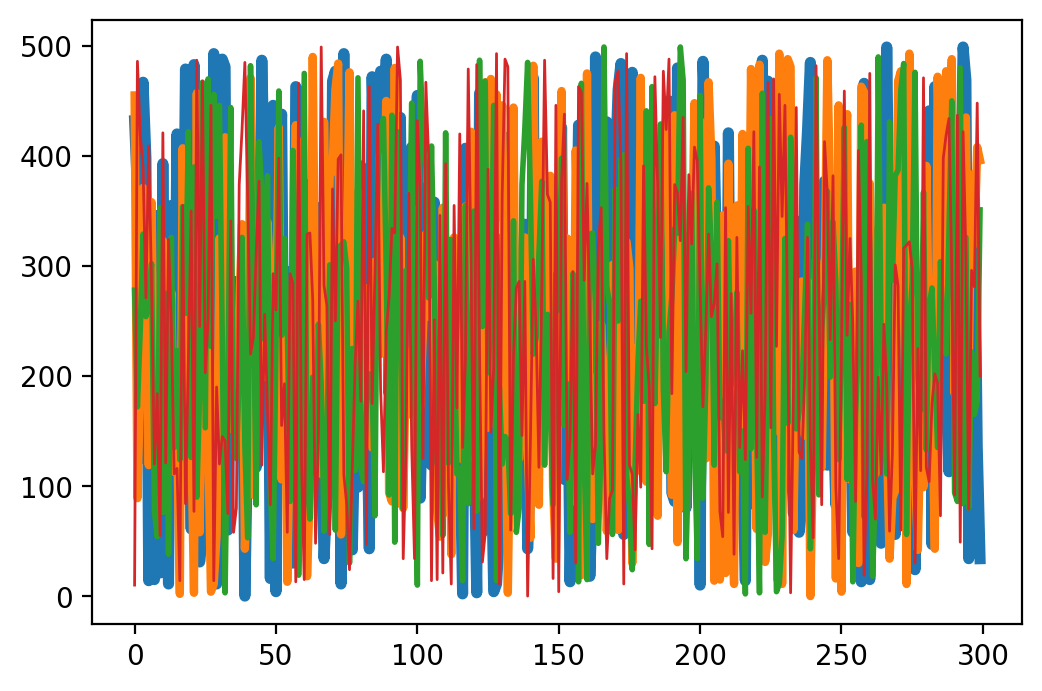

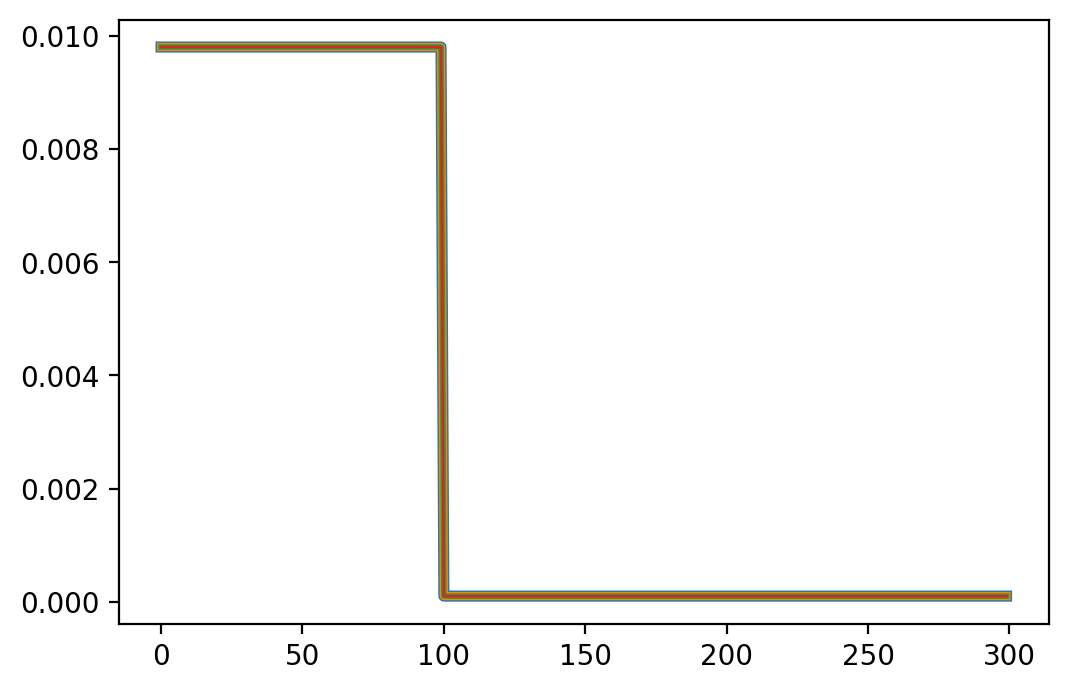

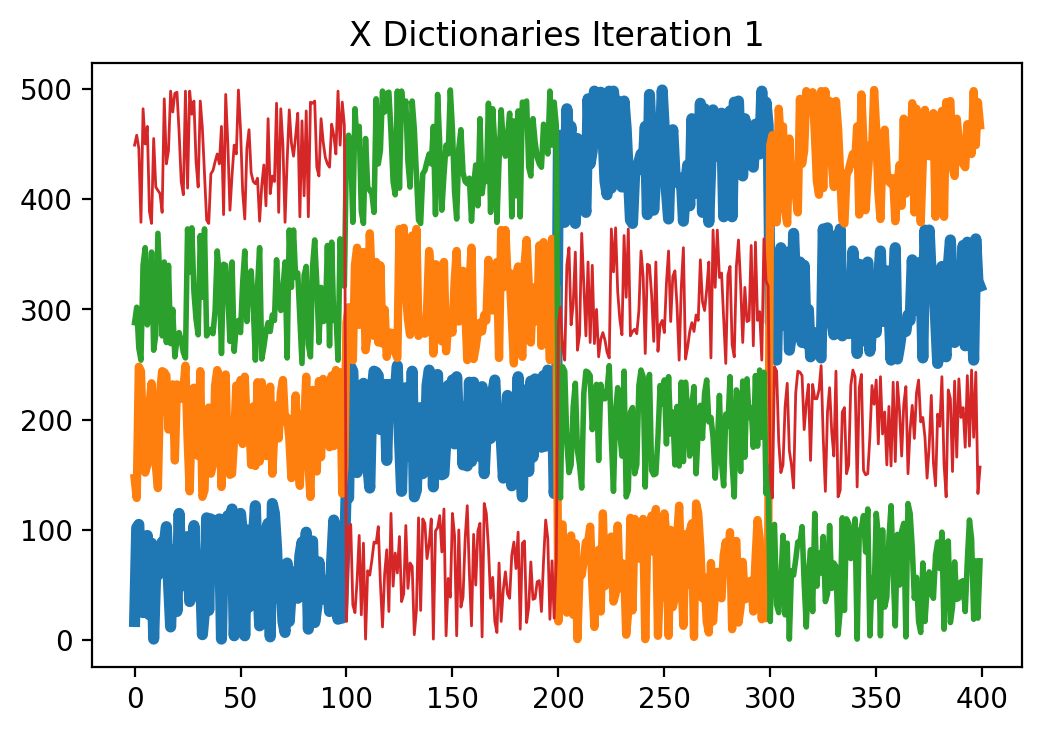

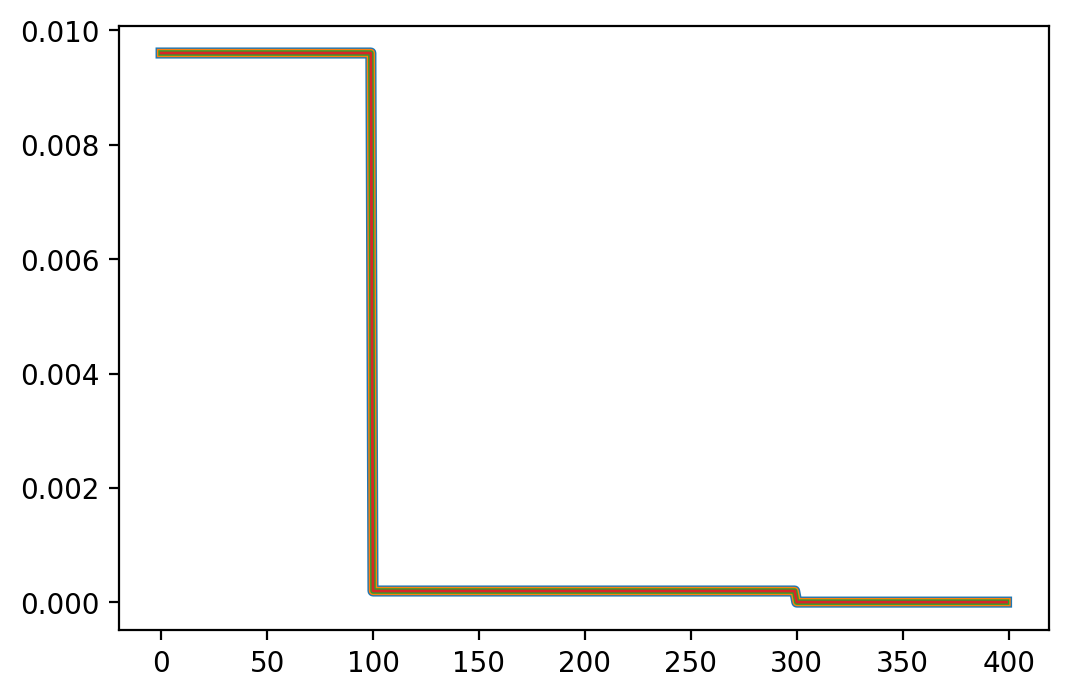

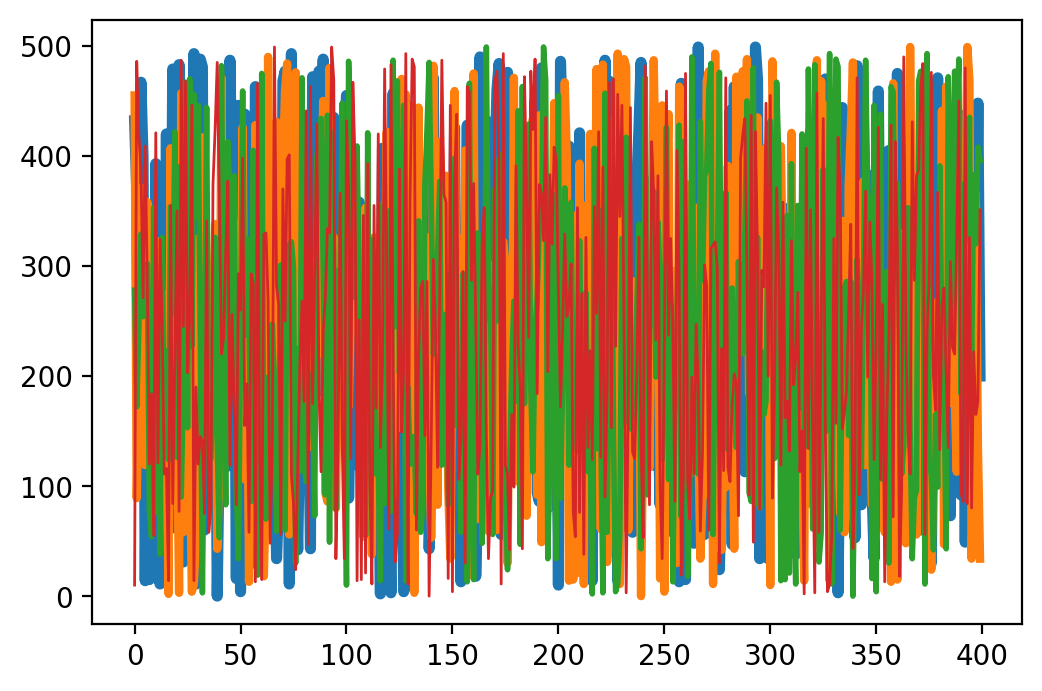

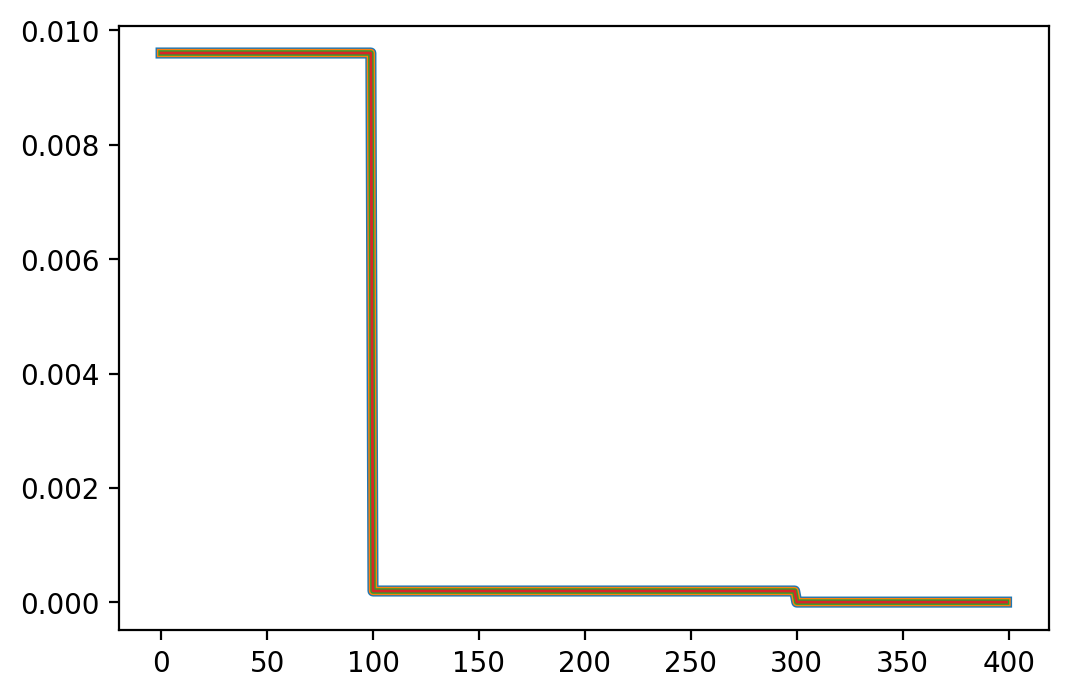

In [17]:
iterateDx = {}
iterateDy = {}
iterateWxx = {}
iterateWyx = {}
print('--------------')
print('Iteration 1')
# for j in range(0,4):
iterations = 2
tempDx = copy.deepcopy(subDx)
tempDy = copy.deepcopy(subDy)

tempweightDxx = copy.deepcopy(weightDxx)
tempweightDyx = copy.deepcopy(weightDyx)

for iter in range(iterations):

    for j in range(num_agents):
        print('--------------')
        print('Working on node ',j)
        #create a cycle list starting from j
        Locallst = cycle(nodelist,start_at=j)
        print('list starting at node',Locallst)
        # concatDx = subDx[j]
        # concatDy = subDy[j]
        # concatWxx = Adj[j][j] * weightDxx[j]
        # concatWyx = Adj[j][j] * weightDyx[j]
        concatDx = tempDx[j]
        concatDy = tempDy[j]
        concatWxx = Adj[j][j] * tempweightDxx[j]
        concatWyx = Adj[j][j] * tempweightDyx[j]
        for i in Locallst[1:]:
            if Adj[j][i] != 0:
                # concatDx = np.concatenate((concatDx,subDx[i]))
                # concatDy = np.concatenate((concatDy,subDy[i])) 
                # concatWxx = np.concatenate((concatWxx,Adj[j][i] * weightDxx[i]))
                # concatWyx = np.concatenate((concatWyx,Adj[j][i] * weightDyx[i]))
                concatDx = np.concatenate((concatDx,tempDx[i]))
                concatDy = np.concatenate((concatDy,tempDy[i])) 
                concatWxx = np.concatenate((concatWxx,Adj[j][i] * tempweightDxx[i]))
                concatWyx = np.concatenate((concatWyx,Adj[j][i] * tempweightDyx[i]))
    #            print('Dictionary before proj',concatDx.shape)
        iterateDx[j],iterateDy[j],dict_inds = compressD(concatDx,concatDy,delta_tol,sigmalist,etalist)
        D_data = iterateDx[j].shape[0]
        print('Shape of projected sparse Dictionary :',D_data)        
        print()      
        #Find sparse weights alpha's
        locGram_ayx,locGram_axx = Grams(iterateDx[j], iterateDy[j], N_kernel,sigmalist,etalist)
        tempGram_ayx,tempGram_axx = tempGrams(concatDx,concatDy,iterateDx[j],iterateDy[j],sigmalist,etalist)
        print(tempGram_ayx.shape)
        iterateWyx[j] = np.matmul(np.matmul(scipy.linalg.pinv(locGram_ayx,rtol=rcond_value),tempGram_ayx), concatWyx)
        iterateWxx[j] = np.matmul(np.matmul(scipy.linalg.pinv(locGram_axx,rtol=rcond_value),tempGram_axx), concatWxx)
    #    print('Shape of projected sparse Weight vector :', iterateWxx[j].shape)
        # del concatDx,concatDy,concatWxx,concatWyx
    
    plt.figure(dpi=200)
    # inds_x = {}
    for a in range(num_agents):
        # inds_x[a] = np.argsort(iterateDx[a].T[0])
        # plt.plot(np.sort(iterateDx[a].T[0]),linewidth = num_agents-a)
        plt.plot(iterateDx[a].T[0],linewidth = num_agents-a)
        # plt.plot(np.sort(iterateDx[1].T[0]))
        # plt.plot(np.sort(iterateDx[2].T[0]))
        # plt.plot(np.sort(iterateDx[3].T[0]))
    plt.title('X Dictionaries Iteration '+str(iter))

    plt.figure(dpi=200)
    for a in range(num_agents):
        plt.plot(iterateWxx[a],linewidth = num_agents-a)
    
    plt.figure(dpi=200)
    # inds_x = {}
    for a in range(num_agents):
        # plt.plot(np.sort(iterateDy[a].T[0]),linewidth = num_agents-a)
        plt.plot(iterateDy[a].T[0],linewidth = num_agents-a)

    plt.figure(dpi=200)
    for a in range(num_agents):
        plt.plot(iterateWyx[a],linewidth = num_agents-a)
    # plt.plot(np.sort(iterateWxx[1]))
    # plt.plot(np.sort(iterateWxx[2]))
    # plt.plot(np.sort(iterateWxx[3]))

    tempDx = copy.deepcopy(iterateDx)
    tempDy = copy.deepcopy(iterateDy)

    tempweightDxx = copy.deepcopy(iterateWxx)
    tempweightDyx = copy.deepcopy(iterateWyx)

In [43]:
#%%=============================================================================
# Iteration 1
# =============================================================================
# iterateDx = {}
# iterateDy = {}
# iterateWxx = {}
# iterateWyx = {}
# print('--------------')
# print('Iteration 1')
iterations = 2

iterateDx = copy.deepcopy(subDx)
iterateDy = copy.deepcopy(subDy)

iterateWxx = copy.deepcopy(weightDxx)
iterateWyx = copy.deepcopy(weightDyx)

dict_sizes = np.zeros((iterations,num_agents))

for iter in range(iterations):
    print('--------------')
    print('Iteration '+str(iter+1))
    for j in range(0,num_agents):
        # print('--------------')
        # print('Working on node ',j)
        #create a cycle list starting from j
        Locallst = cycle(nodelist,start_at=j)
        print('list starting at node',Locallst)
        # concatDx = subDx[j]
        # concatDy = subDy[j]
        concatDx = copy.deepcopy(iterateDx[j])
        concatDy = copy.deepcopy(iterateDy[j])
        # concatWxx = Adj[j][j] * weightDxx[j]
        # concatWyx = Adj[j][j] * weightDyx[j]
        concatWxx = Adj[j][j] * copy.deepcopy(iterateWxx[j])
        concatWyx = Adj[j][j] * copy.deepcopy(iterateWyx[j])
        for i in Locallst[1:]:
            if Adj[j][i] != 0:
                # concatDx = np.concatenate((concatDx,subDx[i]))
                # concatDy = np.concatenate((concatDy,subDy[i])) 
                # concatWxx = np.concatenate((concatWxx,Adj[j][i] * weightDxx[i]))
                # concatWyx = np.concatenate((concatWyx,Adj[j][i] * weightDyx[i]))
                concatDx = np.concatenate((concatDx,iterateDx[i]))
                concatDy = np.concatenate((concatDy,iterateDy[i])) 
                concatWxx = np.concatenate((concatWxx,Adj[j][i] * iterateWxx[i]))
                concatWyx = np.concatenate((concatWyx,Adj[j][i] * iterateWyx[i]))
    #            print('Dictionary before proj',concatDx.shape)
        iterateDx[j],iterateDy[j],dict_inds = compressD(concatDx,concatDy,delta_tol,sigmalist,etalist)
        # D_data = iterateDx[j].shape[0]
        D_data = iterateDx[j].shape
        dict_sizes[iter][j] = iterateDx[j].shape[0]
        print('Shape of projected sparse Dictionary :',D_data)        
        # print()      
        #Find sparse weights alpha's
        locGram_ayx,locGram_axx = Grams(iterateDx[j], iterateDy[j], N_kernel,sigmalist,etalist)
        tempGram_ayx,tempGram_axx = tempGrams(concatDx,concatDy,iterateDx[j],iterateDy[j],sigmalist,etalist)
        # print(tempGram_ayx.shape)
        iterateWyx[j] = np.matmul(np.matmul(scipy.linalg.pinv(locGram_ayx,rtol=rcond_value),tempGram_ayx), concatWyx)
        iterateWxx[j] = np.matmul(np.matmul(scipy.linalg.pinv(locGram_axx,rtol=rcond_value),tempGram_axx), concatWxx)
    #    print('Shape of projected sparse Weight vector :', iterateWxx[j].shape)
        del concatDx,concatDy,concatWxx,concatWyx

--------------
Iteration 1
Shape of projected sparse Dictionary : (1499, 2)
Shape of projected sparse Dictionary : (1999, 2)
Shape of projected sparse Dictionary : (1999, 2)
Shape of projected sparse Dictionary : (1999, 2)
--------------
Iteration 2
Shape of projected sparse Dictionary : (1999, 2)
Shape of projected sparse Dictionary : (1999, 2)
Shape of projected sparse Dictionary : (1999, 2)
Shape of projected sparse Dictionary : (1999, 2)


In [27]:
subX = np.stack([np.load('KTO-duffing/X_0.npy') ,np.load('KTO-duffing/X_1.npy'),np.load('KTO-duffing/X_2.npy'),np.load('KTO-duffing/X_3.npy')],axis=2)
subY = np.stack([np.load('KTO-duffing/Y_0.npy') ,np.load('KTO-duffing/Y_1.npy'),np.load('KTO-duffing/Y_2.npy'),np.load('KTO-duffing/Y_3.npy')],axis=2)

In [28]:
np.shape(subX)

(900, 2, 4)

In [45]:
iterateDy[j].shape

(400, 1)

In [46]:
M_data = dataset_len*num_agents
eps = -0.20
ve = 1e-10 * M_data**eps 

alphas = {}

for j in range(num_agents):

    nx = len(iterateDx[j])
    D_data = iterateDx[j].shape[0]
    KXX = np.zeros((D_data,D_data))

    for k in range(N_kernel):
        KXX += etalist[k] * rbf_kernel(iterateDx[j],gamma=1.0/(2.0*sigmalist[k]**2))
        
    Ayx = np.diag(alpha_yx) * D_data
    Axx = np.diag(alpha_xx) * D_data
    W = Ayx @ np.linalg.inv(KXX@Axx + ve*np.eye(D_data))

    print(D_data)

    alpha = np.zeros((n_state,n_action,D_data))

    for state in range(n_state):
        for action in range(n_action):
            temp_kern = np.zeros((D_data,1))
            for k in range(N_kernel):
                temp_kern += etalist[k] * rbf_kernel(iterateDx[j],np.tile([state,action],[1,1]),gamma=1.0/(2.0*sigmalist[k]**2))
            alpha[state][action] = np.squeeze(W@temp_kern)
            alpha[state][action] = alpha[state][action]/np.sum(np.abs(alpha[state][action]))
    
    alphas[j] = alpha

400
400
400
400


In [49]:
np.shape(alphas[0][state][action])

(400,)

In [51]:
iterateDy[0][0]

array([432.])

In [55]:
j = 0

V = np.zeros((n_state,1))
# V_prod = np.zeros_like(labels)[:,np.newaxis]
# V_prod = np.zeros((Dy.shape[0],1))
V_prod = np.zeros((iterateDy[j].shape[0],1))

theta = 0.001
max_iter = 10000
err = np.infty

gamma = 0.99

iter = 0

deltas = np.zeros(max_iter)

CME_policy = np.zeros(n_state)
while iter<max_iter and err>theta:
    print(iter)
    V_temp = np.zeros_like(V)
    # print('V_temp')
    # print(V_temp)
    # print('V')
    # print(V)
    # V_prod = V[labels]
    V_prod = V[np.squeeze(iterateDy[j]).astype(int)]
    for state in range(n_state):
        max_buffer = np.zeros(n_action)
        for action in range(n_action):
            max_buffer[action] = rewards[state][action] + gamma*(alphas[j][state][action]@V_prod)
        V_temp[state] = np.max(max_buffer)
        CME_policy[state] = np.argmax(max_buffer)
    # print('V_temp')
    # print(V_temp)
    err = np.max(np.abs(V-V_temp))
    deltas[iter] = err
    V = V_temp    
    iter = iter+1
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

KeyboardInterrupt: 

In [39]:
m = len(dataset)

X = dataset.T[0:2].T
Y = dataset.T[2].T[:,np.newaxis]

dxx = pdist(X, 'euclidean')
dx = np.median(dxx)
print('Mean of distance',dx)
print()
sigma_st = np.sqrt(dx)
M_data = X.shape[0]
N_kernel = 1
sigmalist = [sigma_st/4]
#sigmalist = [5./m]
etalist = [1]

Dx,Dy = compressD(X,Y,delta_tol,sigmalist,etalist)        
D_data = Dx.shape[0]        
print('Final shape of Dictionary :',D_data)        
print()  

m_d = Dx.shape[0]
pairwise_sq_dists = squareform(pdist(Dx,metric='sqeuclidean'))
# K = np.exp(-pairwise_sq_dists / sigma_kernel**2)
K = np.exp(-pairwise_sq_dists / (2*sigmalist[0]**2))
W = np.linalg.inv(K + lamd*m_d*np.eye(m_d))

# alphas = np.zeros((n_state,n_action,m))
alphas = np.zeros((n_state,n_action,m_d))

for state in range(n_state):
    for action in range(n_action):
        # dists = cdist(data_in,np.tile([state,action],[1,1]),metric='sqeuclidean')
        dists = cdist(Dx,np.tile([state,action],[1,1]),metric='sqeuclidean')
        #alphas[state][action] = np.squeeze(W@np.exp(-dists/sigma_kernel**2))
        alphas[state][action] = np.squeeze(W@np.exp(-dists/(2*sigmalist[0]**2)))
        alphas[state][action] = alphas[state][action]/np.sum(np.abs(alphas[state][action]))


Mean of distance 29.154759474226502

Final shape of Dictionary : 4683



KeyboardInterrupt: 

In [56]:
V_VI = np.zeros(n_state)

theta = 0.001
max_iter = 10000
err = np.infty

gamma = 0.99

iter = 0

deltas = []

VI_policy = np.zeros(n_state)
while iter<max_iter and err>theta:
    print(iter)
    V_temp = np.zeros_like(V_VI)
    # print('V_temp')
    # print(V_temp)
    # print('V')
    # print(V)
    for state in range(n_state):
        # V_prod[labels] = V[labels]
        max_buffer = np.zeros(n_action)
        for action in range(n_action):
            max_buffer[action] = rewards[state][action] + gamma*(np.dot(V_VI,t_matrix[state][action]))
        V_temp[state] = np.max(max_buffer)
        VI_policy[state] = np.argmax(max_buffer)
    # print('V_temp')
    # print(V_temp)
    err = np.max(np.abs(V_VI-V_temp))
    deltas.append(err)
    V_VI = V_temp    
    iter = iter+1

deltas = np.array(deltas)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

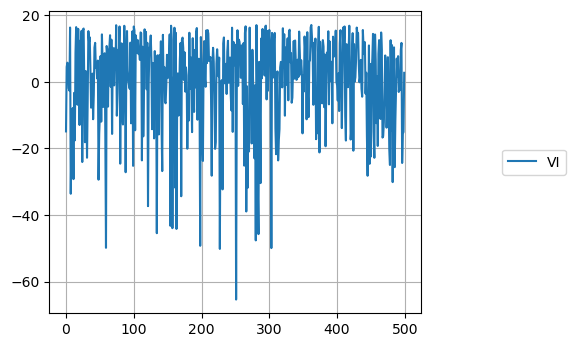

In [59]:
t = np.arange(n_state)

fig, ax1 = plt.subplots(dpi=100)

ax1.plot(V_VI-np.mean(V_VI),label='VI')
# ax1.plot(V-np.mean(V),label='CME Approx VI')

box = ax1.get_position()
ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax1.legend(loc='center left',bbox_to_anchor=(1.2, 0.5))

plt.grid()

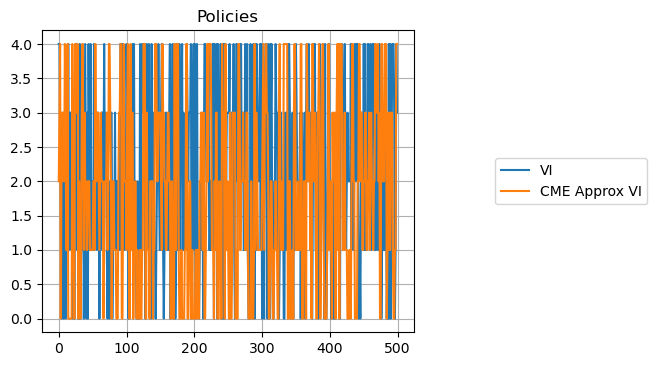

In [58]:
t = np.arange(n_state)

fig, ax1 = plt.subplots(dpi=100)

ax1.plot(VI_policy,label='VI')
ax1.plot(CME_policy,label='CME Approx VI')

box = ax1.get_position()
ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax1.legend(loc='center left',bbox_to_anchor=(1.2, 0.5))
ax1.set_title('Policies')

plt.grid()